In [1]:
#savistky golay filtering is the most common spectral denoising method.
# we will compare our cycleGAN's denoised spectra to those smoothed with savistky golay filtering
# https://www.datatechnotes.com/2022/05/smoothing-example-with-savitzky-golay.html

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


noisy_va = np.load('hn_valid_set.npy')
clean_va = np.load('ln_valid_set.npy')

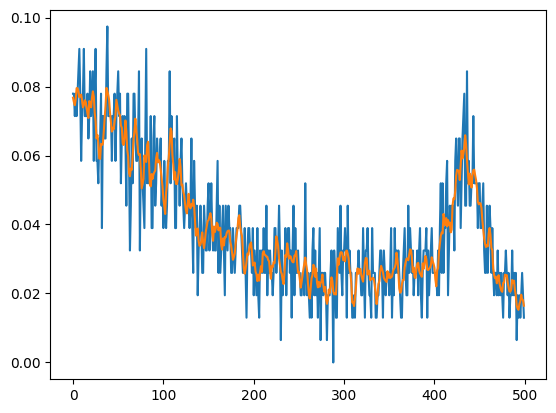

In [2]:


test_example = np.squeeze(noisy_va[0,:])
y_smooth = signal.savgol_filter(test_example, window_length=11, polyorder=3, mode="nearest")

plt.plot(test_example)
plt.plot(y_smooth)



In [3]:
#PCA denoising - https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html

from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=32)
kernel_pca = KernelPCA(
    n_components=400, kernel="rbf", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3
)

pca.fit(noisy_va)
_ = kernel_pca.fit(noisy_va)

X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
    kernel_pca.transform(noisy_va)
)


In [4]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(np.expand_dims(noisy_va[0,:],axis=0)))

In [5]:
print(np.shape(X_reconstructed_pca))
test_example = np.squeeze(noisy_va[0,:])


(1, 500)


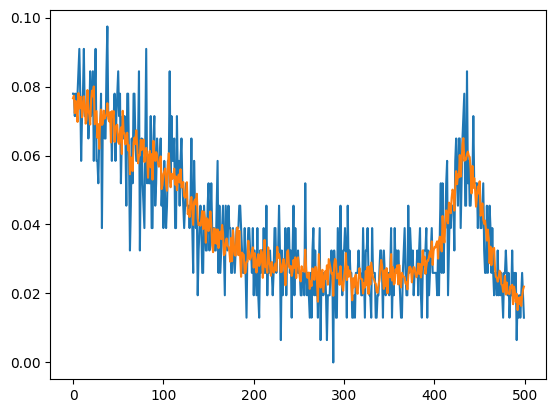

In [6]:
plt.plot(test_example)
plt.plot(np.squeeze(X_reconstructed_pca))


In [7]:
import numpy as np
#import PyWavelets as pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt

x_denoise = denoise_wavelet(test_example, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')

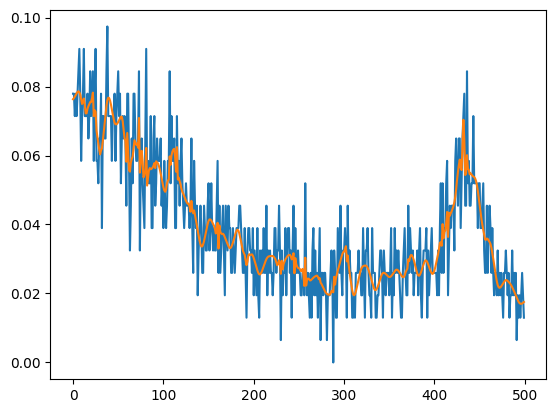

In [8]:
plt.plot(test_example)
plt.plot(np.squeeze(x_denoise))

